# Online Chess Games - Exploration

Chess is a two-player strategy board game that has been around since the 6th century and played by millions worldwide.  Lichess.org is a major online chess server that is open-source.  In this notebook, I have performed an exploration on this [Dataset](https://www.kaggle.com/datasnaek/chess) of ~20,000 chess games from a selection* of users on the site Lichess.org.

*The selection criteria for the ~20,000 games: they were the most recent (as of Sept. 3rd, 2017, the dataset's creation) games taken from users of the top ~100 teams on Lichess.

As an amateur chess player, I have wondered if there are quantifiable differences between a low-rated chess game and a top-tier game.  There are plenty of possible factors to consider, but I have chosen a few factors worth investigating.  The basic outlines follows:

**Contents**

[1. Dataset preparation](#1)
<br>[2. Overall Observations](#2)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Mean Rating](#2.1)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Victory Status](#2.2)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.3 White Advantage](#2.3)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Length of Games](#2.4)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.1 Number of Turns to Mate](#2.4.1)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.5 Wins by Lower Rated Players (Upsets)](#2.5)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.6 Castling Preference](#2.6)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.7 Opening Preference](#2.7)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.1 Favor White](#2.7.1)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.2 Favor Black](#2.7.2)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.3 Favor Draws](#2.7.3)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.4 Scholar's Mate](#2.7.4)
<br>[3. Conclusion](#3)

## <a id="1">1. Dataset Preparation</a>

As the first step, let us import the required libraries, load the dataset, check for missing data, remove duplicates, and create some additional features.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import ttest_ind
import re
from statistics import mode
%matplotlib inline

#Read csv file
games = pd.read_csv('games.csv') #both rated and unrated games


#Check if there are any missing data
print("Missing Data:  ", games.isnull().values.any())

#Inital Data Size Check
initial_size = games.shape[0]
print("Initial Size:  ", initial_size)

#Remove duplicates
games = games.drop_duplicates('id', 'first')

#Data Size Check
final_size = games.shape[0]
print("Duplicates: ".ljust(15), initial_size - final_size)
print("Final Size:  ".ljust(15), final_size)

Missing Data:   False
Initial Size:   20058
Duplicates:     945
Final Size:     19113


### Additional Features

These additional features are new columns that will get used later on, such as the mean rating of the game (average of the two player's ratings) and the overall difference between the ratings (absolute value of the difference between the ratings of the two player's ratings).  We will also be splitting the dataset into three brackets: below average, above average, and top-tier.

#### New Columns

In [2]:
#Adding another column calculating average of two player's ratings to get the game's rating
games['mean_rating'] = (games['white_rating'] + games['black_rating']) / 2

#New column for the difference in ratings
games['rating_difference'] = abs(games['white_rating'] - games['black_rating'])

#### Breaking into Brackets

In [3]:
#Breaking games up by brackets: below average, above average, top tier
under_1500 = games[games.mean_rating <= 1500]
under_2000 = games[(games.mean_rating < 2000) & (games.mean_rating > 1500)]
over_2000 = games[games.mean_rating >= 2000]

brackets = [under_1500, under_2000, over_2000]
bracket_titles = ['Under 1500', '1500-2000', 'Over 2000']

#### Common Functions to Output Common Graphs

In [4]:
#HISTOGRAM
#As I will be using this often...
#Defining a function that will create a histrogram with mean/std lines
#along with additional information underneath
def GamesHist(df, bins, color, column, xname, title):
    #Finding average and standard deviation of Column
    nd_mean = np.mean(df[column])
    nd_std = np.std(df[column])
    
    #Creating Histogram
    plt.figure(figsize=(15,5))

    plt.hist(df[column], bins=bins, color=color)
    plt.title(title)
    plt.xlabel(xname)
    plt.ylabel('Number of Games')
    plt.axvline(x=nd_mean, color = 'red')
    plt.axvline(x=nd_mean + nd_std, color = 'green')
    plt.axvline(x=nd_mean - nd_std, color = 'green')
    plt.show()
    
    #Printing additional info
    print( 'mode     ', mode(df[column]))
    print( df[column].describe())
    
#Pie Chart of Overall Data    
def OverallPie(column_of_interest):
    plt.figure(figsize=(5,5))
    plt.title('Overall')
    
    stats = games[column_of_interest].value_counts()
    plt.pie(stats, labels = stats.index, autopct='%.1f%%', shadow=True)
    plt.show()
    
#3 Pies for Each Bracket
def BracketPie(column_of_interest):
    plt.figure(figsize=(15,11))
    for i, bracket in enumerate(brackets):
        stats = bracket[column_of_interest].value_counts()
        plt.subplot(1, 3, i+1)
        plt.title(bracket_titles[i])
        plt.pie(stats, labels = stats.index, autopct='%.1f%%', shadow=True)

All players rating starts at a tentative 1500 which increases or decreases based on game performance.  For further details on how Lichess calculates a player's ratings, visit their [FAQ](https://lichess.org/faq#ratings).

<br>**Below 1500** = Below Average
<br>**1500-2000** = Above Average, but not top tier
<br>**Above 2000** *(world champion sits around 2500)* = Top tier

## <a id="2">2. Overall Observations</a>

The overall question we're asking is if there are quantifiable differences between differently-rated games.  Each player is given a *rating* on the site proportional to their skill (higher is better).  How do higher-skilled players play differently from lower-skilled players?

There are many factors we are considering.  Each section contains a factor for consideration, which will often be checked against the overall dataset before being compared between different rating brackets.  First, let's check the database for the size of each bracket.

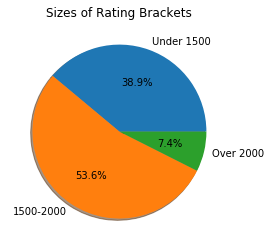

In [5]:
#Checking size of brackets
bracket_sizes = [under_1500.shape[0], under_2000.shape[0], over_2000.shape[0]]

plt.figure(figsize=(4,4))
plt.title('Sizes of Rating Brackets')
plt.pie(bracket_sizes, labels = bracket_titles, autopct='%.1f%%', shadow=True)
plt.show()

Right away, we can see a bias as over half the games covered are in the "above-average" bracket, while less than 10% of the games cover the "top-tier" bracket.  Let's check the overall rating distribution of the players.

### <a id="2.1">2.1 Mean Rating</a>

We can calculate the average rating of the game by taking the mean of the two player's ratings.

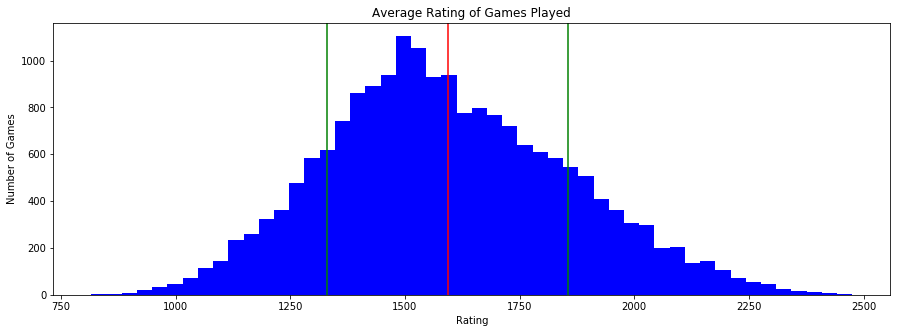

mode      1500.0
count    19113.000000
mean      1593.672762
std        262.541423
min        816.500000
25%       1409.500000
50%       1570.000000
75%       1772.500000
max       2475.500000
Name: mean_rating, dtype: float64


In [6]:
GamesHist(df=games, bins=50, color='blue', column='mean_rating', xname='Rating', title='Average Rating of Games Played')

That chart shows what the average rating is of the games played.  The mode of 1500 is not surprising as all players starting out has that rating, so that would be the most popular rating.  A normal-distribution is not a surprising shape for the histrogram to take.

### <a id="2.2">2.2 Victory Status</a>

There are four different ways for a game to end: 
+ getting checkmated *(mate)*, 
+ admitting defeat before getting checkmated *(resigning)* 
+ one side runs out of time *(out of time)*
+ neither side can win *(draw)*

Is there a difference between high/low rated players?

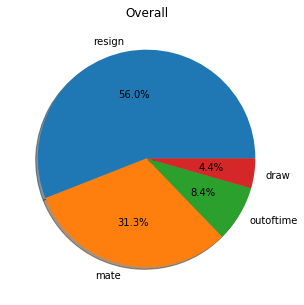

In [7]:
OverallPie('victory_status')

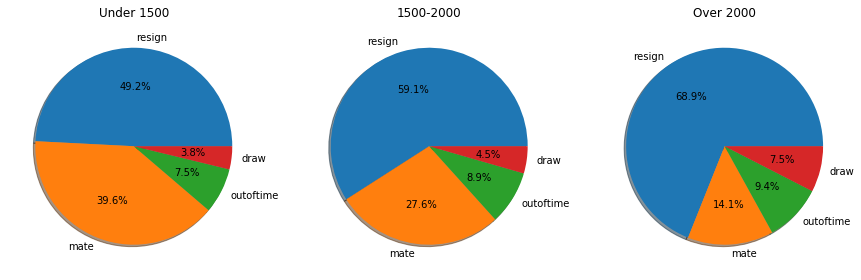

In [8]:
BracketPie('victory_status')

We see here that resignition is more likely the higher the rating.  A few possible reasons:
+ Players are more experienced and can recognize a lost position
+ Players at higher ratings trust their opponent will be able to capitalize on their advantage and choose to save time
+ Lower-rated players may not be experienced enough to recognize a lost or winning position
+ Lower-rated players are more likely to blunder and lose their advantage
    + It's always worth to keep playing until the end

### <a id="2.3">2.3 White Advantage</a>

Whoever goes first in a turn-based game has an inherient advantage.  How much of an advantage do those playing white get?  Does it differ based on rating levels?

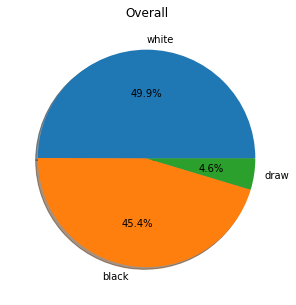

In [9]:
OverallPie('winner')

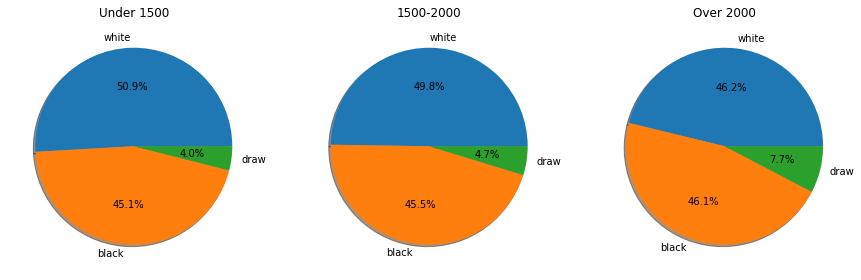

In [10]:
BracketPie('winner')

White does have a slight advantage, but it appears to even out the higher rated the games get.

Do note that it has been studied numerous times with the conclusion being that [white does have the advantage](https://en.wikipedia.org/wiki/First-move_advantage_in_chess) by going first.  Do note that these games being played are often on a severe time restriction (5 minutes per side is pretty common) so the players are often not playing the optimal move all the time.

### <a id="2.4">2.4 Length of Games</a>

How many moves are in a typical game, including all types of win conditions (mating, resigning, out-of-time, draw).

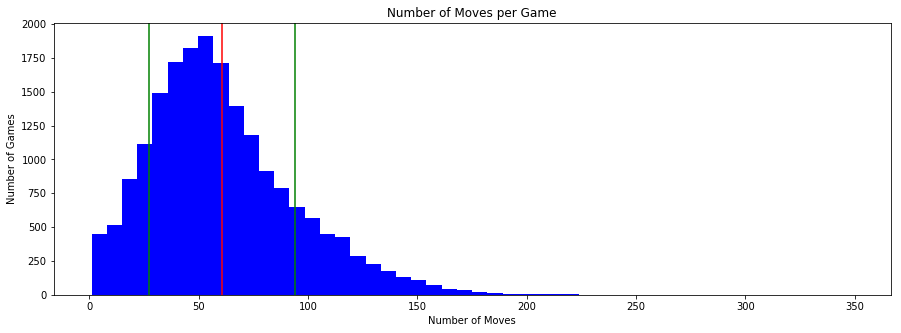

mode      45
count    19113.000000
mean        60.513839
std         33.488264
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64


In [11]:
GamesHist(games, 50, 'blue', column='turns', xname='Number of Moves', title='Number of Moves per Game')

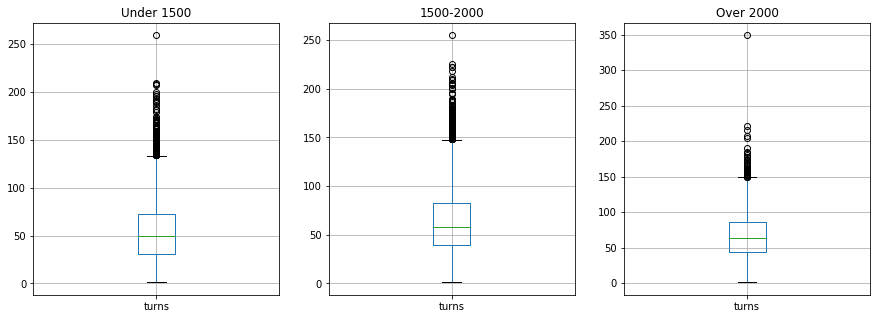

In [12]:
#boxplot
plt.figure(figsize=(15,5))
for i, bracket in enumerate(brackets):
    plt.subplot(1, 3, i+1)
    plt.title(bracket_titles[i])
    bracket.boxplot(column=['turns'])

#### <a id="2.4.1">2.4.1 Number of Turns to Mate</a>

What is the average number of moves that leads to mate?

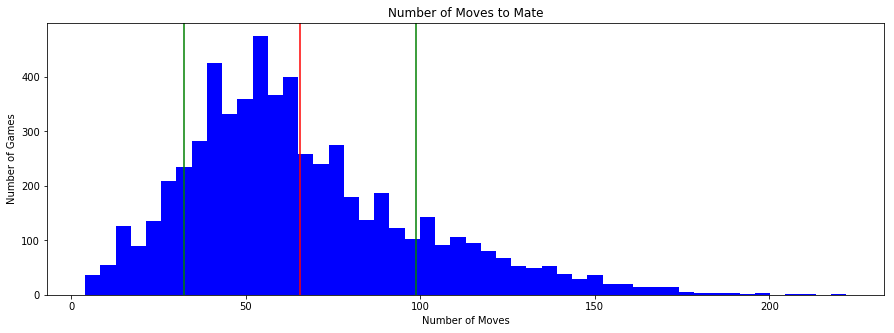

mode      52
count    5974.000000
mean       65.568966
std        33.166256
min         4.000000
25%        42.000000
50%        59.000000
75%        83.000000
max       222.000000
Name: turns, dtype: float64


In [13]:
#New DataFrame for only games that end in Mate
games_mate = games.loc[games['victory_status'] == 'mate']

GamesHist(games_mate, 50, 'blue', 'turns', 'Number of Moves', 'Number of Moves to Mate')

In [14]:
#Split previous DataFrame into rating Brackets
mate_under_1500 = under_1500[under_1500.victory_status=='mate']
mate_under_2000 = under_2000[under_2000.victory_status=='mate']
mate_over_2000 = over_2000[over_2000.victory_status=='mate']

m_brackets = [mate_under_1500, mate_under_2000, mate_over_2000]

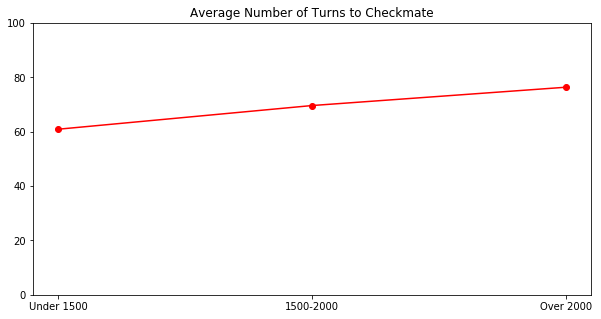

In [15]:
#Graph the average number of turns for each bracket/DataFrame
turn_means = [b.turns.mean() for b in m_brackets]

plt.figure(figsize=(10,5))
plt.ylim(0,100)
plt.title('Average Number of Turns to Checkmate')
plt.plot(bracket_titles, turn_means, 'o-', color='red')
plt.show()

### <a id="2.5">2.5 Wins by Lower Ranked Players (Upsets)</a>

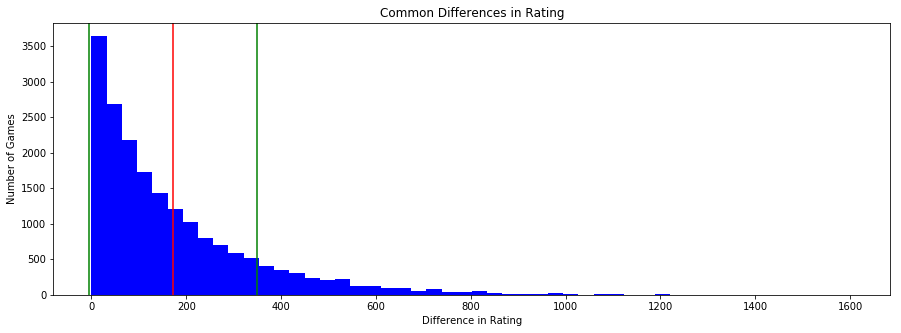

mode      0
count    19113.000000
mean       172.336786
std        177.702696
min          0.000000
25%         46.000000
50%        115.000000
75%        240.000000
max       1605.000000
Name: rating_difference, dtype: float64


In [16]:
GamesHist(games, 50, 'blue', 'rating_difference', 'Difference in Rating', 'Common Differences in Rating')

In [17]:
#Create new DataFrame for games with an upset (lower-rated player wins)
white_upsets = games[(games.winner == 'white') & (games.white_rating < games.black_rating)]
black_upsets = games[(games.winner == 'black') & (games.black_rating < games.white_rating)]
games_upsets = pd.concat([white_upsets, black_upsets])

In [18]:
# Print out the percentages depending on the rating difference
threshold = 900
step = 50

u_percentages = []

print('rating difference : Percentage of wins by weaker player')
for i in range(0+step, threshold, step):
    th_upsets = games_upsets[(games_upsets['rating_difference'] > i) & (games_upsets['rating_difference'] <= i+step)]
    th_games = games[(games['rating_difference'] > i) & (games['rating_difference'] <= i+step)]
    upsets_percentage = (th_upsets.shape[0] / th_games.shape[0]) * 100
    u_percentages.append([i, upsets_percentage])
    print(f'{str(i).ljust(18)}: {upsets_percentage:.2f}%')

rating difference : Percentage of wins by weaker player
50                : 38.94%
100               : 34.19%
150               : 31.69%
200               : 23.59%
250               : 23.41%
300               : 20.44%
350               : 17.04%
400               : 14.69%
450               : 16.34%
500               : 12.95%
550               : 13.51%
600               : 14.29%
650               : 15.74%
700               : 8.74%
750               : 12.50%
800               : 4.84%
850               : 3.70%


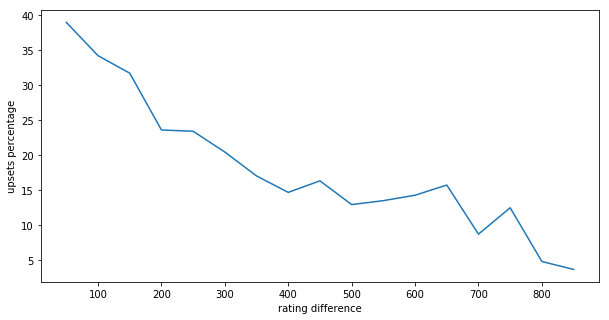

In [19]:
plt.figure(figsize=(10,5))
plt.plot(*zip(*u_percentages))
#plt.plot(u_percentages)
plt.xlabel('rating difference')
plt.ylabel('upsets percentage')
plt.show()

### <a id="2.6">2.6 Castling Preference</a>

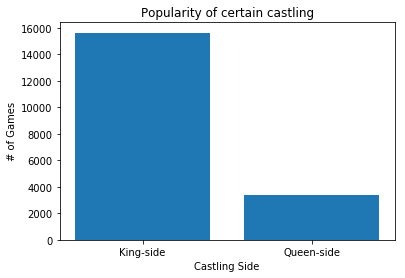

In [20]:
# New DataFrames with games that include certain castling
king_games = games.loc[games['moves'].str.contains('O-O ', flags=re.I, regex=True)]
queen_games = games.loc[games['moves'].str.contains('O-O-O', flags=re.I, regex=True)]

# Data to Plot
castling_games = ['King-side', 'Queen-side']
castling = [king_games.shape[0], queen_games.shape[0]]

# Bar Plot
fig, ax = plt.subplots()
plt.bar(castling_games, castling)
plt.title('Popularity of certain castling')
plt.ylabel('# of Games')
plt.xlabel('Castling Side')
plt.show()

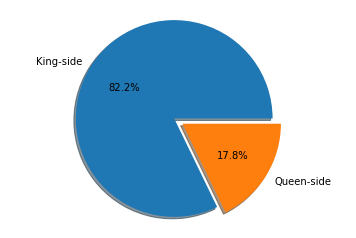

In [21]:
# Data to plot
castle_labels = ['King-side', 'Queen-side']
castle_sizes = [king_games.shape[0], queen_games.shape[0]]
castle_explode = (0.1, 0)  # explode 1st slice because it looks cool

# Plot
plt.pie(castle_sizes, explode=castle_explode, labels=castle_labels,
autopct='%1.1f%%', shadow=True)

plt.axis('equal')
plt.show()

In [22]:
king_under_1500 = king_games[king_games.mean_rating < 1500]
king_under_2000 = king_games[(king_games.mean_rating < 2000) & (king_games.mean_rating >= 1500)]
king_over_2000 = king_games[king_games.mean_rating > 2000]

queen_under_1500 = queen_games[queen_games.mean_rating < 1500]
queen_under_2000 = queen_games[(queen_games.mean_rating < 2000) & (queen_games.mean_rating >= 1500)]
queen_over_2000 = queen_games[queen_games.mean_rating > 2000]

king_brackets = [king_under_1500.shape[0], king_under_2000.shape[0], king_over_2000.shape[0]]
queen_brackets = [queen_under_1500.shape[0], queen_under_2000.shape[0], queen_over_2000.shape[0]]
bracket_titles = ['Under 1500', 'Under 2000', 'Over 2000']

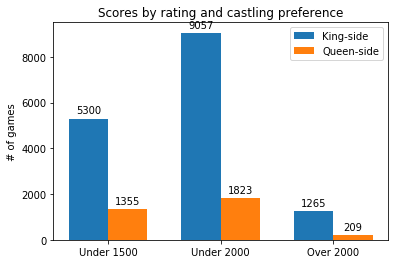

In [23]:
x = np.arange(len(bracket_titles))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, king_brackets, width, label='King-side')
rects2 = ax.bar(x + width/2, queen_brackets, width, label='Queen-side')

# Text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of games')
ax.set_title('Scores by rating and castling preference')
ax.set_xticks(x)
ax.set_xticklabels(bracket_titles)
ax.legend()


def autolabel(rects):
    #Attach a text label above each bar in *rects*, displaying its height.
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()

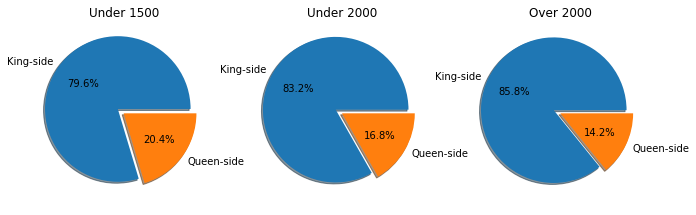

In [24]:
plt.figure(figsize=(15,11))
for i, bracket in enumerate(brackets):
    castle = [king_brackets[i], queen_brackets[i]]
    plt.subplot(1, 4, i+1)
    plt.title(bracket_titles[i])
    plt.pie(castle, labels = castle_labels, autopct='%.1f%%', explode=castle_explode, shadow=True)

### <a id="2.7">2.7 Opening Preference</a>

Does a certain type of opening favor a certain color?

In [25]:
white_wins = games[games.winner == 'white']
black_wins = games[games.winner == 'black']
draw_games = games[games.winner == 'draw']

In [26]:
w_openings = white_wins.groupby(['opening_name']).count()['id']
w_openings = w_openings.sort_values(ascending=False)[0:10]

b_openings = black_wins.groupby(['opening_name']).count()['id']
b_openings = b_openings.sort_values(ascending=False)[0:10]

d_openings = draw_games.groupby(['opening_name']).count()['id']
d_openings = d_openings.sort_values(ascending=False)[0:10]

#### <a id="2.7.1">2.7.1 Favor White</a>

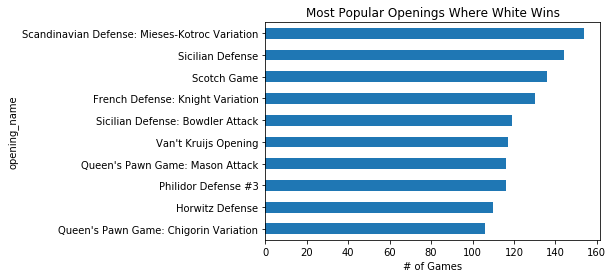

In [27]:
# data
aw = w_openings.plot.barh(rot=0)

aw.invert_yaxis()  # labels read top-to-bottom
aw.set_xlabel('# of Games')
aw.set_title('Most Popular Openings Where White Wins')

plt.show()

#### <a id="2.7.2">2.7.2 Favor Black</a>

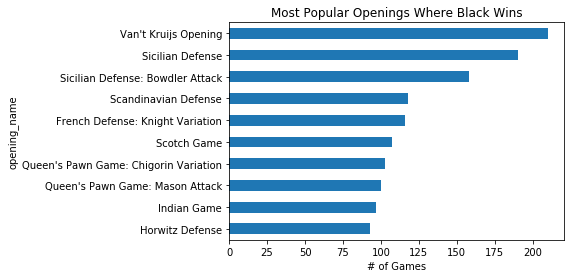

In [28]:
# data
ab = b_openings.plot.barh(rot=0)

ab.invert_yaxis()  # labels read top-to-bottom
ab.set_xlabel('# of Games')
ab.set_title('Most Popular Openings Where Black Wins')

plt.show()

#### <a id="2.7.3">2.7.3 Favor Draws</a>

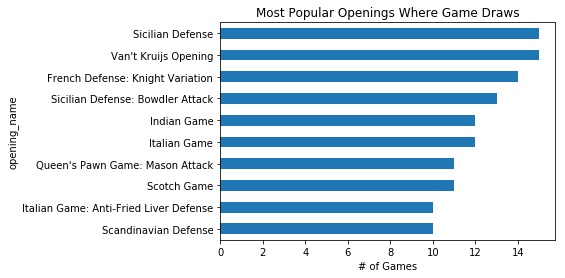

In [29]:
# data
ad = d_openings.plot.barh(rot=0)

ad.invert_yaxis()  # labels read top-to-bottom
ad.set_xlabel('# of Games')
ad.set_title('Most Popular Openings Where Game Draws')

plt.show()

#### <a id="2.7.4">2.7.4 Scholar's Mate</a>

## <a id="3">3. Conclusion</a>

#### Summary:
+ Over half the games take place in the above-average rating (1500-2000)
+ Less than 10% of the games have a mean rating above 2000 (top-tier)
+ Average rating is ~1600 with std of ~260
+ Top tier games end in resignation ~50% more than below-average rating games
+ Top tier games end in draws ~100% more than below-average rating games
+ White advantage evens out during the top-tier games (similar percentage of black and white wins)
+ Below-average games on average end sooner than top-tier
+ The lower the game rating, the greater the chance of there being an upset
+ Overall, a strong preference to castle king-side
+ Top-tier games even less likely to castle queen-side

#### Flaws/Improvements for next time
+ Ideally should only compare players with known ratings
+ Average ratings based on number of games
+ New players have a default rating of 1500
    + Should remove from database players that only play once
